## population influx として、上準位からの放射脱励起は考えなくてもいいのか

In [ ]:
ne = 0.0001
Te = 0.5

In [ ]:
fermi = Fermi(states3, equ=False, Te=Te, ne=ne)
scores, population = fermi.get_population()

In [ ]:
C = np.dot(np.diag(population), fermi.excitation)
F = fermi.deexcitation * population
A = fermi.emission * population

print('''
C[i, j] = excitation[i, j] * population[i]
    → 状態 i から状態 j に遷移

F[i, j] = deexcitation[i, j] * population[j]
    → 状態 j から状態 i への遷移
''')


C[i, j] = excitation[i, j] * population[i]
    → 状態 i から状態 j に遷移

F[i, j] = deexcitation[i, j] * population[j]
    → 状態 j から状態 i への遷移



In [ ]:
# 基底状態からの励起で各状態 i に入ってくる influx
influx_C_from_ground = C[0]
influx_C_except_ground = np.sum(C[1:], axis=0)
influx_F = np.sum(F, axis=1)
influx_A = np.sum(A, axis=1)

In [ ]:
scores_per_energy = []
influx_C_from_ground_per_energy = []
influx_C_except_ground_per_energy = []
influx_A_per_energy = []
influx_F_per_energy = []

idx = -1
previous_score = -1 # 適当な値
for score, c_ground, c, a, f in zip(scores, influx_C_from_ground, influx_C_except_ground, influx_A, influx_F):
    if score == previous_score:
        influx_C_from_ground_per_energy[idx] += c_ground
        influx_C_except_ground_per_energy[idx] += c
        influx_A_per_energy[idx] += a
        influx_F_per_energy[idx] += f
    else:
        scores_per_energy.append(score)
        influx_C_from_ground_per_energy.append(c_ground)
        influx_C_except_ground_per_energy.append(c)
        influx_A_per_energy.append(a)
        influx_F_per_energy.append(f)
        idx += 1
        previous_score = score

In [ ]:
percentage_influx_C_from_ground_per_energy = []
percentage_influx_C_except_ground_per_energy = []
percentage_influx_A_per_energy = []
percentage_influx_F_per_energy = []

for c_ground, c, f, a in zip(influx_C_from_ground_per_energy, influx_C_except_ground_per_energy, influx_F_per_energy, influx_A_per_energy):
    total = c_ground + c + f + a
    percentage_influx_C_from_ground_per_energy.append(c_ground / total)
    percentage_influx_C_except_ground_per_energy.append(c / total)
    percentage_influx_A_per_energy.append(a / total)
    percentage_influx_F_per_energy.append(f / total)

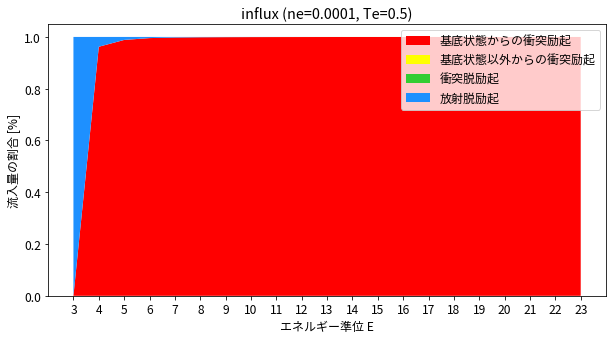

In [ ]:
labels = ["基底状態からの衝突励起", "基底状態以外からの衝突励起", "衝突脱励起","放射脱励起"]
# plt.figure(figsize=(40, 30))
plt.figure(figsize=(10, 5))
plt.stackplot(scores_per_energy, 
              percentage_influx_C_from_ground_per_energy,
              percentage_influx_C_except_ground_per_energy,
              percentage_influx_F_per_energy, 
              percentage_influx_A_per_energy,
              labels=labels, colors=["Red", "Yellow", "LimeGreen", "DodgerBlue"]
              # 赤, オレンジ, 緑, 青
            )
# plt.stackplot(scores_per_energy, 
#               percentage_influx_C_from_ground_per_energy,
#               percentage_influx_C_except_ground_per_energy,
#               percentage_influx_F_per_energy, 
#               percentage_influx_A_per_energy,
#               labels=labels, colors=["white", "white", "blue", "yellow"]
#             )
plt.xlabel("エネルギー準位 E")
plt.ylabel("流入量の割合 [%]")
plt.title(f"influx (ne={ne}, Te={Te})")
plt.xticks(scores_per_energy)
plt.legend()
plt.show()
# 各エネルギー準位について和をとり、それぞれのエネルギー準位のinfluxの和が1になるように正規化した

### 元の問題
* ~~構築した理論モデルが計算結果と一致しない→近似のやり方があっているのか？~~
  * 実はそこまで間違っていませんでした。しかしちょっとの誤差はある。。
* グラフの結果から、近似のやり方、つまり「どの(脱)励起のみを考えればよいのか」という考え方はあってそう。
  * ほんとうにそうか? 遷移可能でないやつに押されているだけで、遷移可能な奴らに関しては放射脱励起で入ってくる量の方が優勢かもしれへん
  * 各微視的状態ごとではなく、各エネルギー準位ごとの占有密度分布の数式を出すだけなら、この近似は間違いないが、各微視的状態ごとの占有密度を数式で表そうと思ったら、この近似だけではだめで、遷移可能かどうかも考慮しないと<span style="color: red">**絶対**</span>にダメ
* 理論モデルをより数値解に近いようにするには？
  * 縮退度の式がおかしい -> より厳密な近似式を使ってみる?

### 結果
* 基底状態を除き、その状態に入ってくるのは基底状態からの衝突励起によるものがほとんど。


### 考えるべきこと 
* ここまでのやり方は、微視的状態ごとではなく、エネルギー準位ごとに和をとっている。だから、放射脱励起が衝突励起よりも優勢となっている状態があっても、それがわからない？

* 藤井先生によると、上準位における基底状態からの衝突励起はもっと小さそう
    * 23εの準位とかだと、それより上の準位がないので、放射脱励起で落ちてくるものがない。
    * しかも上準位ほど(Ei-Ej)の差が小さくなり、放射脱励起で落ちてくるもの自体の大きさが小さい(考えているのは、そのエネルギー状態においての流入量に占める放射脱励起の割合なので、単純に絶対的な値が小さいからといって、流入量のうちの放射脱励起の割合が小さくなるとは限らないが。)
    * なので、上準位におけるinfluxのうち、放射脱励起の占める割合が小さい。
* (あってるんかはわからんけど)このグラフを見る限り、構築した理論モデルで近似のやり方は正しそう。なのに占有密度のグラフはあんまりあってない。
    * 縮退度の式が間違っている or 理論モデルでは遷移可能や不可能を扱えてないのが問題
<br>

### やりたいこと
* ne, Te に対する依存度を確認する
    * neを大きくすると、放射脱励起の影響が小さくなり、衝突脱励起と衝突励起のみのグラフになるはず(つまり、青の面積が小さくなり、オレンジ、緑、赤の面積が大きくなるはず)

* **各微視的状態に関して、グラフ化は難しいかもしれんけど、衝突励起・衝突脱励起・放射脱励起のパーセントをだしたい。**
    * 遷移可能かどうかや、基底状態の電子配置と近いかとかを考えたい
    * 


* 縮退を無視してることが関係ある？(基底状態からの遷移のしやすさ)
* 理論モデルがなぜ間違っていたのかが本題
    * 縮退度の式が間違っている
    * 遷移可能かどうかを考慮していない
    
* **理論モデルで行った積分計算とかを、遷移可能かとかを考慮して、理論からではなく自分で数値計算する**

とりあえず outflux のグラフも作っとく

In [ ]:
outflux_C = np.sum(C, axis=1)
outflux_F = np.sum(F, axis=0)
outflux_A = np.sum(A, axis=0)

scores_per_energy = []
outflux_C_per_energy = []
outflux_A_per_energy = []
outflux_F_per_energy = []

idx = -1
previous_score = -1 # 適当な値
for score, c, a, f in zip(scores, outflux_C, outflux_A, outflux_F):
    if score == previous_score:
        outflux_C_per_energy[idx] += c
        outflux_A_per_energy[idx] += a
        outflux_F_per_energy[idx] += f
    else:
        scores_per_energy.append(score)
        outflux_C_per_energy.append(c)
        outflux_A_per_energy.append(a)
        outflux_F_per_energy.append(f)
        idx += 1
        previous_score = score

percentage_outflux_C_per_energy = []
percentage_outflux_A_per_energy = []
percentage_outflux_F_per_energy = []

for c, f, a in zip(outflux_C_per_energy, outflux_F_per_energy, outflux_A_per_energy):
    total =  c + f + a
    percentage_outflux_C_per_energy.append(c / total)
    percentage_outflux_A_per_energy.append(a / total)
    percentage_outflux_F_per_energy.append(f / total)

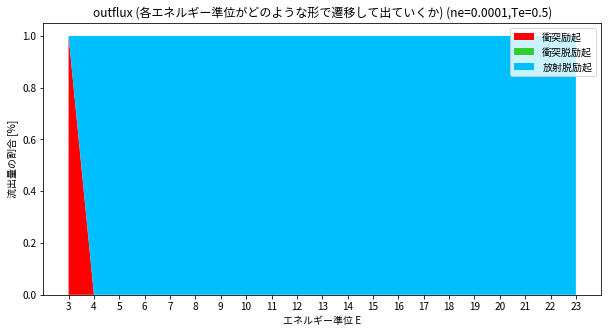

In [ ]:
labels = ["衝突励起", "衝突脱励起","放射脱励起"]
# plt.figure(figsize=(40, 30))
plt.figure(figsize=(10, 5))
plt.stackplot(scores_per_energy, 
              percentage_outflux_C_per_energy,
              percentage_outflux_F_per_energy, 
              percentage_outflux_A_per_energy,
              labels=labels, colors=["#ff0000", "#32cd32", "#00bfff"]
            )
plt.xlabel("エネルギー準位 E")
plt.ylabel("流出量の割合 [%]")
plt.title(f"outflux (各エネルギー準位がどのような形で遷移して出ていくか) (ne={ne},Te={Te})")
plt.xticks(scores_per_energy)
plt.legend()
plt.show()

### 結果
* 基底状態以外は、放射脱励起として出ていく。
* この図だけでは、どの状態からその状態に入ってきたのかがわからない。
* outflux に関しては、占有密度が関係なく、ただのその微視的状態からの(脱)励起レートの比

## neの値を変えて、fluxの値を出す
TODO: 色の設定がきもすぎるので、もうちょいパステルチックな色にする

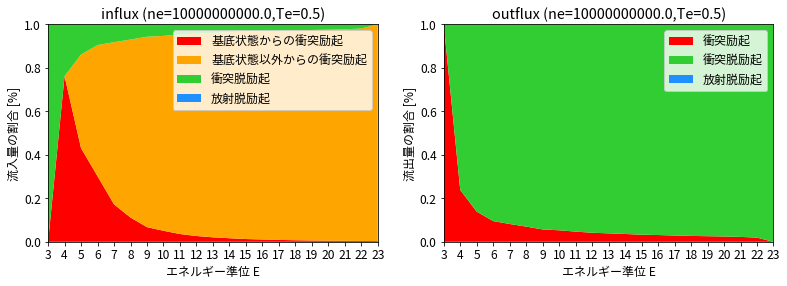

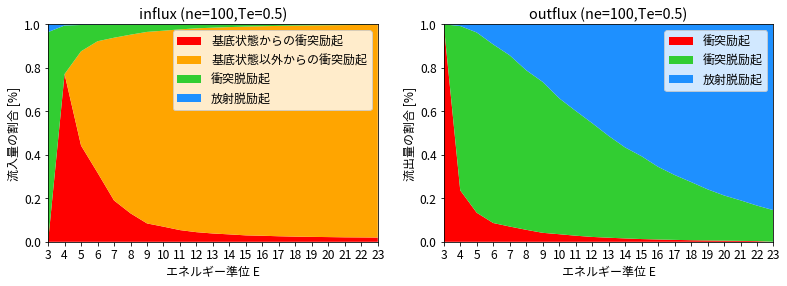

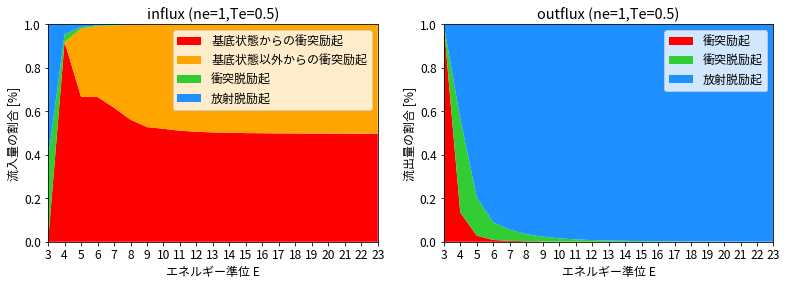

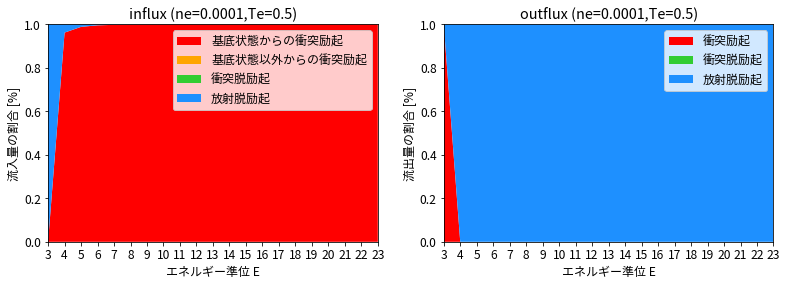

In [ ]:
from fermi_model import *

ne_lst = [1e+10, 100, 1, 0.0001]
plots_percentage_fluxes(ne_lst, Te=0.5)

### 考察(influxについて)
* neが大きくなるにしたがって、基底状態が支配的になっていく。それに伴い、基底状態からの衝突励起の占める割合も大きくなる。
* 高励起状態では基底状態から遷移できないものも多いので、一見基底状態からの衝突励起が優勢になっているのがおかしいように思えるが、縮退した同じエネルギー準位をとる状態たちの中で、基底状態と電子配置が近いものがより大きな占有密度をとり、またそいつの基底状態からの衝突励起してくるinfluxの値の絶対値も大きいので、そいつらの影響がおよんで、基底状態から遷移できない状態が多いにも関わらず高励起状態でも基底状態からの衝突励起が優勢となる。要は平均の取り方の問題。
* ただ、各状態についてのinfluxの衝突励起、衝突脱励起、放射脱励起の占める割合も出すことができるが、グラフ化することができない

